In [341]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [342]:
!pip install pmdarima

In [343]:
# 필요한 함수, 모듈 업로드
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt

In [344]:
df = pd.read_csv('/content/drive/MyDrive/외생변수/temp_df_final.csv', index_col = 0).iloc[:, 1:]

df2 = pd.read_csv('/content/drive/MyDrive/섹터ETF취합/Add_TI_섹터ETF/TIGER200_커뮤니케이션서비스_TI.csv', index_col = 0)
# df

In [345]:
# Converting 'stateDt' to datetime format
df['stateDt'] = pd.to_datetime(df['stateDt'], format='%Y%m%d')

# Renaming the 'stateDt' column to 'Date'
df.rename(columns={'stateDt': 'Date'}, inplace=True)

df.tail()  # Display the last few rows to check the changes

,Date,decideCnt,deathCnt
1106,2023-04-15,30978954.0,34368.0
1107,2023-04-17,30994088.0,34376.0
1108,2023-04-18,31009261.0,34386.0
1109,2023-04-19,31025769.0,34392.0
1110,2023-04-20,31039863.0,34401.0


In [346]:
# '날짜'와 '종가' 컬럼 이름 변경
df2.rename(columns={'날짜': 'Date', '종가': 'Close'}, inplace=True)
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')
df2['diff_5'] = df2['Close'].pct_change(5)

df2.head()  # 변경된 데이터프레임의 마지막 몇 행을 확인합니다.

,Date,Close,diff_5,diff_20,ma_5,ma_20
1119,2019-09-05,16325.0,NaN,0.035850,16435.0,16142.50
1118,2019-09-06,16385.0,NaN,0.032777,16457.0,16168.50
1117,2019-09-09,16530.0,NaN,0.026708,16462.0,16190.00
1116,2019-09-10,16530.0,NaN,0.037665,16457.0,16220.00
1115,2019-09-11,16540.0,NaN,0.044522,16462.0,16255.25


In [347]:
# df에서 decideCnt와 deathCnt의 차이를 계산하고, 이를 %로 변환
df['decideCnt_diff'] = df['decideCnt'].diff().fillna(0)
df['deathCnt_diff'] = df['deathCnt'].diff().fillna(0)
# df
df['decideCnt_diff_perc'] = df['decideCnt_diff'] / df['decideCnt_diff'].shift(5)
df['deathCnt_diff_perc'] = df['deathCnt_diff'] / df['deathCnt_diff'].shift(5)
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # 무한대 값을 NaN으로 대체

# df2와 df를 'Date' 기준으로 합치기
df_combined = pd.merge(df2, df[['Date', 'decideCnt_diff_perc', 'deathCnt_diff_perc']], on='Date', how='outer')

# NaN이 포함된 행 제거
df_combined.dropna(inplace=True)

df_combined.tail()

,Date,Close,diff_5,diff_20,ma_5,ma_20,decideCnt_diff_perc,deathCnt_diff_perc
891,2023-04-14,19070.0,0.038106,0.067749,18685.0,18384.25,1.173288,1.250000
892,2023-04-17,18950.0,0.031573,0.048990,18801.0,18428.50,1.216168,0.800000
893,2023-04-18,18775.0,0.008324,0.030461,18832.0,18456.25,1.089545,0.714286
894,2023-04-19,18680.0,0.006737,0.002146,18857.0,18458.25,1.423594,1.200000
895,2023-04-20,18575.0,-0.012493,0.010884,18810.0,18468.25,1.208126,1.800000


In [348]:
df_combined


,Date,Close,diff_5,diff_20,ma_5,ma_20,decideCnt_diff_perc,deathCnt_diff_perc
116,2020-02-27,17980.0,-0.040043,-0.003326,18330.0,18336.00,2.205240,0.500000
117,2020-02-28,17555.0,-0.058713,-0.016802,18111.0,18321.00,3.378698,0.000000
118,2020-03-02,17475.0,-0.041415,-0.016878,17960.0,18306.00,1.676056,2.000000
119,2020-03-03,17635.0,-0.044691,-0.020006,17795.0,18288.00,1.188119,6.000000
121,2020-03-05,18395.0,0.023081,0.003272,17883.0,18308.00,0.538745,0.750000
...,...,...,...,...,...,...,...,...
891,2023-04-14,19070.0,0.038106,0.067749,18685.0,18384.25,1.173288,1.250000
892,2023-04-17,18950.0,0.031573,0.048990,18801.0,18428.50,1.216168,0.800000
893,2023-04-18,18775.0,0.008324,0.030461,18832.0,18456.25,1.089545,0.714286
894,2023-04-19,18680.0,0.006737,0.002146,18857.0,18458.25,1.423594,1.200000


## [auto_arima를 통한 ARIMA 모델 파라메터 설정]



In [349]:
# AutoARIMA 모델 학습(ARIMA) - 왜인지는 모르겠는데 변수로 지정하면 안 나오고, 이렇게 직접 입력하면 잘 나옴. 지금 AIC가 더 내려간 것으로 미루어 더 유의미하며, 심지어 decideCnt_diff_perc의 경우에도 alphba = 0.05 하에서 유의미
auto_arima_model = auto_arima(df_combined['diff_5'], seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

Arima_results = auto_arima_model.summary()

results_summary = str(Arima_results)
print(results_summary)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3267.615, Time=2.91 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2656.202, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3280.867, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3042.454, Time=1.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2657.782, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3281.990, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-3282.517, Time=0.26 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-3285.168, Time=1.73 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-3289.039, Time=0.99 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-3307.626, Time=5.01 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-3282.312, Time=4.60 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-3316.604, Time=6.69 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-3281.846, Time=5.59 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-3326.313, Time=7.40 sec
 ARIMA(4,0,3)(0,0,0

## [auto_arima를 통한 ARIMAX 모델 파라메터 설정]

In [350]:
# AutoARIMA 모델 학습(ARIMAX) - 왜인지는 모르겠는데 변수로 지정하면 안 나오고, 이렇게 직접 입력하면 잘 나옴. 지금 AIC가 더 내려간 것으로 미루어 더 유의미하며, 심지어 decideCnt_diff_perc의 경우에도 alphba = 0.05 하에서 유의미
auto_arimax_model = auto_arima(df_combined['diff_5'], df_combined[['deathCnt_diff_perc']]
, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

Arimax_results = auto_arimax_model.summary()

results_summary = str(Arimax_results)
print(results_summary)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3274.095, Time=3.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2654.291, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3279.026, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3040.582, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2656.255, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3280.115, Time=1.39 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-3280.702, Time=2.61 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-3283.228, Time=2.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-3287.273, Time=3.06 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-3302.135, Time=5.73 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-3277.182, Time=4.80 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-3315.237, Time=7.34 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-3272.205, Time=6.37 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-3320.296, Time=7.03 sec
 ARIMA(4,0,3)(0,0,0

## [ARIMA 모델 학습 및 summary]

In [351]:
# ARIMA 모델 적합 및 결과 요약 출력을 위한 수정된 코드
from statsmodels.tsa.arima.model import ARIMA
Arima_Model = ARIMA(df_combined['diff_5'], order = auto_arima_model.order,
                    enforce_stationarity=False,  # Depending on your data you might want to set this to False
                       enforce_invertibility=False)

# 모델 학습
Arima_results = Arima_Model.fit()
Arima_results_summary = Arima_results.summary()

# 결과를 문자열로 변환하여 라인별로 처리 가능하게 만듦
Arima_results_str = str(Arima_results_summary)
print(Arima_results_str)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 diff_5   No. Observations:                  697
Model:                 ARIMA(0, 0, 4)   Log Likelihood                1668.323
Date:                Fri, 17 May 2024   AIC                          -3324.647
Time:                        16:34:22   BIC                          -3297.409
Sample:                             0   HQIC                         -3314.112
                                - 697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.003     -0.198      0.843      -0.006       0.005
ma.L1          0.8302      0.025     32.777      0.000       0.781       0.880
ma.L2          0.6633      0.030     22.436      0.0

In [352]:
# 모델에서 예측값 생성
# 학습 데이터에 대한 "in-sample" 예측을 위해, 예측 기간의 exog 데이터로 학습에 사용된 것과 같은 데이터를 사용합니다.
Arima_predicted_change = Arima_results.predict(n_periods = len(df_combined))

# 예측값을 데이터프레임에 추가
df_combined['predicted_change_arima'] = Arima_predicted_change

df_combined

,Date,Close,diff_5,diff_20,ma_5,ma_20,decideCnt_diff_perc,deathCnt_diff_perc,predicted_change_arima
116,2020-02-27,17980.0,-0.040043,-0.003326,18330.0,18336.00,2.205240,0.500000,-0.000567
117,2020-02-28,17555.0,-0.058713,-0.016802,18111.0,18321.00,3.378698,0.000000,-0.000567
118,2020-03-02,17475.0,-0.041415,-0.016878,17960.0,18306.00,1.676056,2.000000,-0.000567
119,2020-03-03,17635.0,-0.044691,-0.020006,17795.0,18288.00,1.188119,6.000000,-0.000567
121,2020-03-05,18395.0,0.023081,0.003272,17883.0,18308.00,0.538745,0.750000,-0.000567
...,...,...,...,...,...,...,...,...,...
891,2023-04-14,19070.0,0.038106,0.067749,18685.0,18384.25,1.173288,1.250000,0.027925
892,2023-04-17,18950.0,0.031573,0.048990,18801.0,18428.50,1.216168,0.800000,0.025371
893,2023-04-18,18775.0,0.008324,0.030461,18832.0,18456.25,1.089545,0.714286,0.026661
894,2023-04-19,18680.0,0.006737,0.002146,18857.0,18458.25,1.423594,1.200000,0.005404


## [ARIMAX 모델 학습 및 summary]

In [353]:
# SARIMAX 모델 적합 및 결과 요약 출력을 위한 수정된 코드

# ARIMAX 모델 적합
Arimax_Model = SARIMAX(df_combined['diff_5'],
                exog = df_combined['deathCnt_diff_perc'],
                order = auto_arimax_model.order,
                       enforce_stationarity=False,  # Depending on your data you might want to set this to False
                       enforce_invertibility=False)

# 모델 학습
Arimax_results = Arimax_Model.fit()

Arimax_results_summary = Arimax_results.summary()

# 결과를 문자열로 변환하여 라인별로 처리 가능하게 만듦
Arimax_results_str = str(Arimax_results_summary)
print(Arimax_results_str)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 diff_5   No. Observations:                  697
Model:               SARIMAX(0, 0, 4)   Log Likelihood                1668.604
Date:                Fri, 17 May 2024   AIC                          -3325.208
Time:                        16:34:24   BIC                          -3297.971
Sample:                             0   HQIC                         -3314.674
                                - 697                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
deathCnt_diff_perc     0.0005      0.001      0.729      0.466      -0.001       0.002
ma.L1                  0.8313      0.025     32.762      0.000       0.782       0.881
ma.L2               

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [354]:
Arimax_predicted_change = Arimax_results.predict(n_periods = len(df_combined), exog=df_combined['deathCnt_diff_perc'])

# 예측값을 데이터프레임에 추가
df_combined['predicted_change_arimax'] = Arimax_predicted_change

df_combined

,Date,Close,diff_5,diff_20,ma_5,ma_20,decideCnt_diff_perc,deathCnt_diff_perc,predicted_change_arima,predicted_change_arimax
116,2020-02-27,17980.0,-0.040043,-0.003326,18330.0,18336.00,2.205240,0.500000,-0.000567,0.000238
117,2020-02-28,17555.0,-0.058713,-0.016802,18111.0,18321.00,3.378698,0.000000,-0.000567,0.000000
118,2020-03-02,17475.0,-0.041415,-0.016878,17960.0,18306.00,1.676056,2.000000,-0.000567,0.000951
119,2020-03-03,17635.0,-0.044691,-0.020006,17795.0,18288.00,1.188119,6.000000,-0.000567,0.002852
121,2020-03-05,18395.0,0.023081,0.003272,17883.0,18308.00,0.538745,0.750000,-0.000567,0.000357
...,...,...,...,...,...,...,...,...,...,...
891,2023-04-14,19070.0,0.038106,0.067749,18685.0,18384.25,1.173288,1.250000,0.027925,0.029003
892,2023-04-17,18950.0,0.031573,0.048990,18801.0,18428.50,1.216168,0.800000,0.025371,0.025315
893,2023-04-18,18775.0,0.008324,0.030461,18832.0,18456.25,1.089545,0.714286,0.026661,0.026883
894,2023-04-19,18680.0,0.006737,0.002146,18857.0,18458.25,1.423594,1.200000,0.005404,0.006034


## [실제값과 ARIMA, ARIMAX 모델 예측값 그래프]

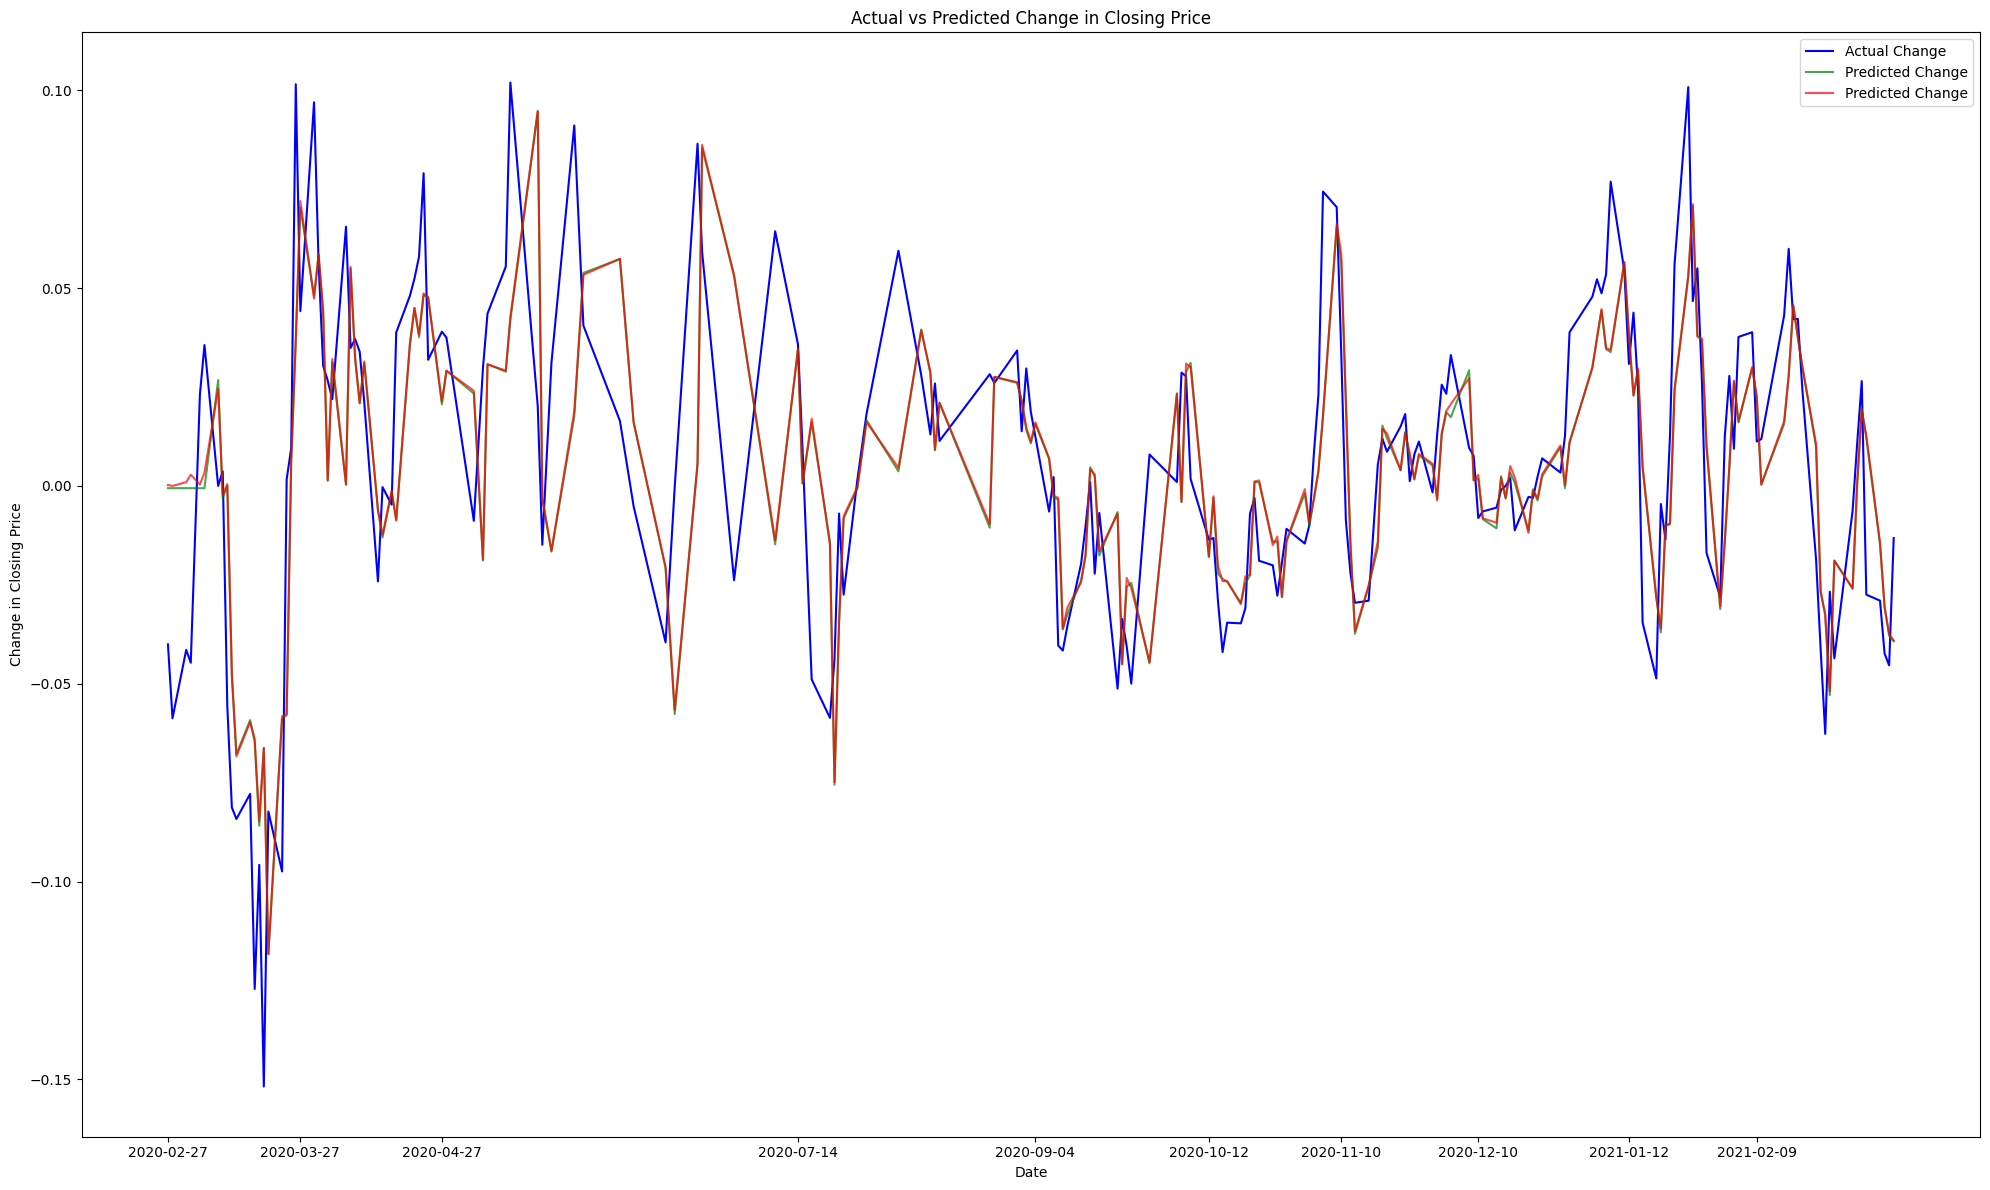

In [355]:
# 실제 종가 변화율과 ARIMA로 예측된 변화율을 시각화합니다.
plt.figure(figsize=(20, 12))
plt.plot(df_combined['Date'].iloc[:200], df_combined['diff_5'].iloc[:200], label='Actual Change', color='blue')
plt.plot(df_combined['Date'].iloc[:200], df_combined['predicted_change_arima'].iloc[:200], label='Predicted Change', color='green', alpha=0.7)
plt.plot(df_combined['Date'].iloc[:200], df_combined['predicted_change_arimax'].iloc[:200], label='Predicted Change', color='red', alpha=0.7)
plt.title('Actual vs Predicted Change in Closing Price')
plt.xlabel('Date')
plt.ylabel('Change in Closing Price')
plt.xticks(df_combined['Date'].iloc[:200][::20])
plt.tight_layout()
plt.legend()
plt.show()

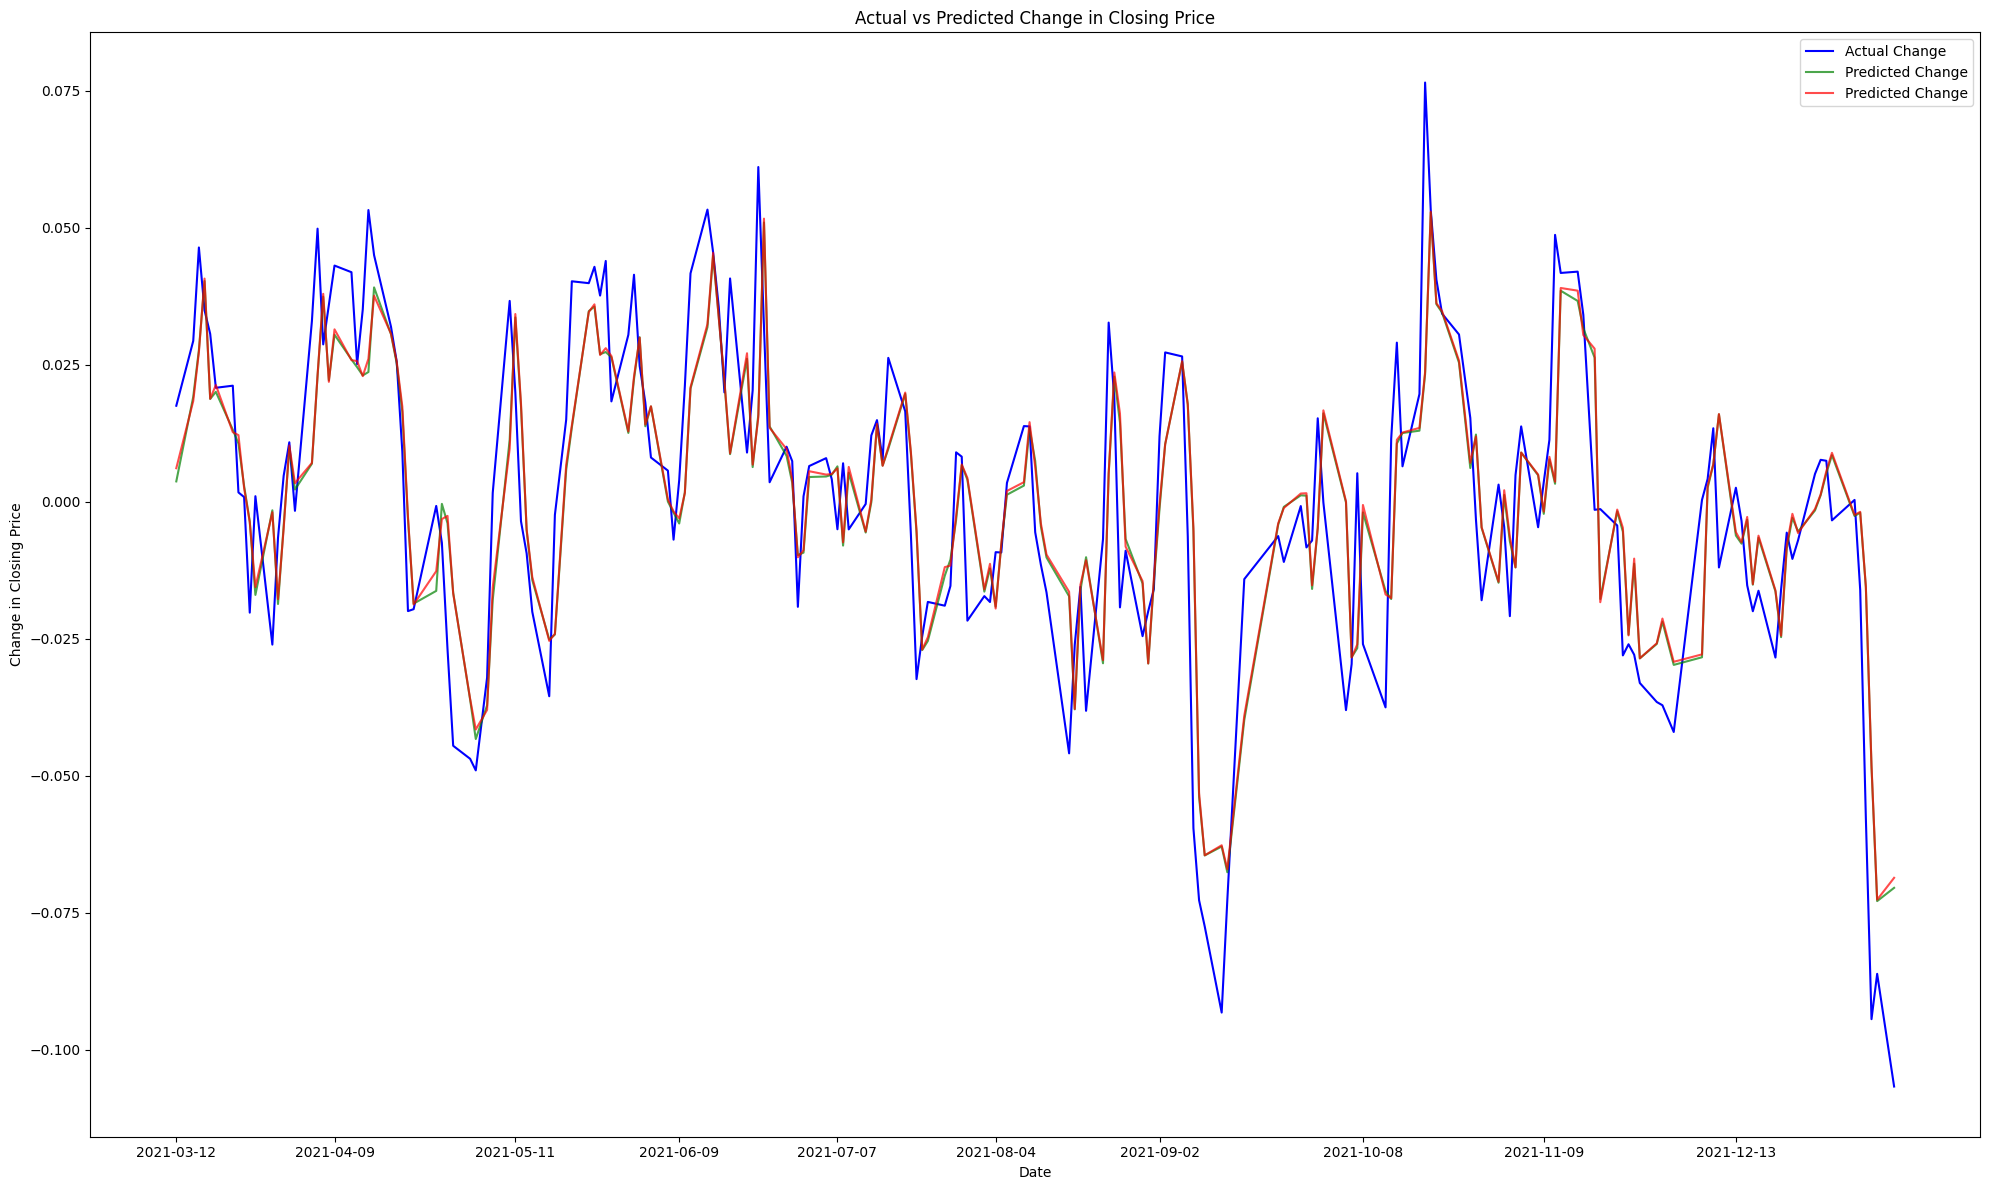

In [356]:
# 실제 종가 변화율과 ARIMA로 예측된 변화율을 시각화합니다.
plt.figure(figsize=(20, 12))
plt.plot(df_combined['Date'].iloc[200:400], df_combined['diff_5'].iloc[200:400], label='Actual Change', color='blue')
plt.plot(df_combined['Date'].iloc[200:400], df_combined['predicted_change_arima'].iloc[200:400], label='Predicted Change', color='green', alpha=0.7)
plt.plot(df_combined['Date'].iloc[200:400], df_combined['predicted_change_arimax'].iloc[200:400], label='Predicted Change', color='red', alpha=0.7)
plt.title('Actual vs Predicted Change in Closing Price')
plt.xlabel('Date')
plt.ylabel('Change in Closing Price')
plt.xticks(df_combined['Date'].iloc[200:400][::20])
plt.tight_layout()
plt.legend()
plt.show()

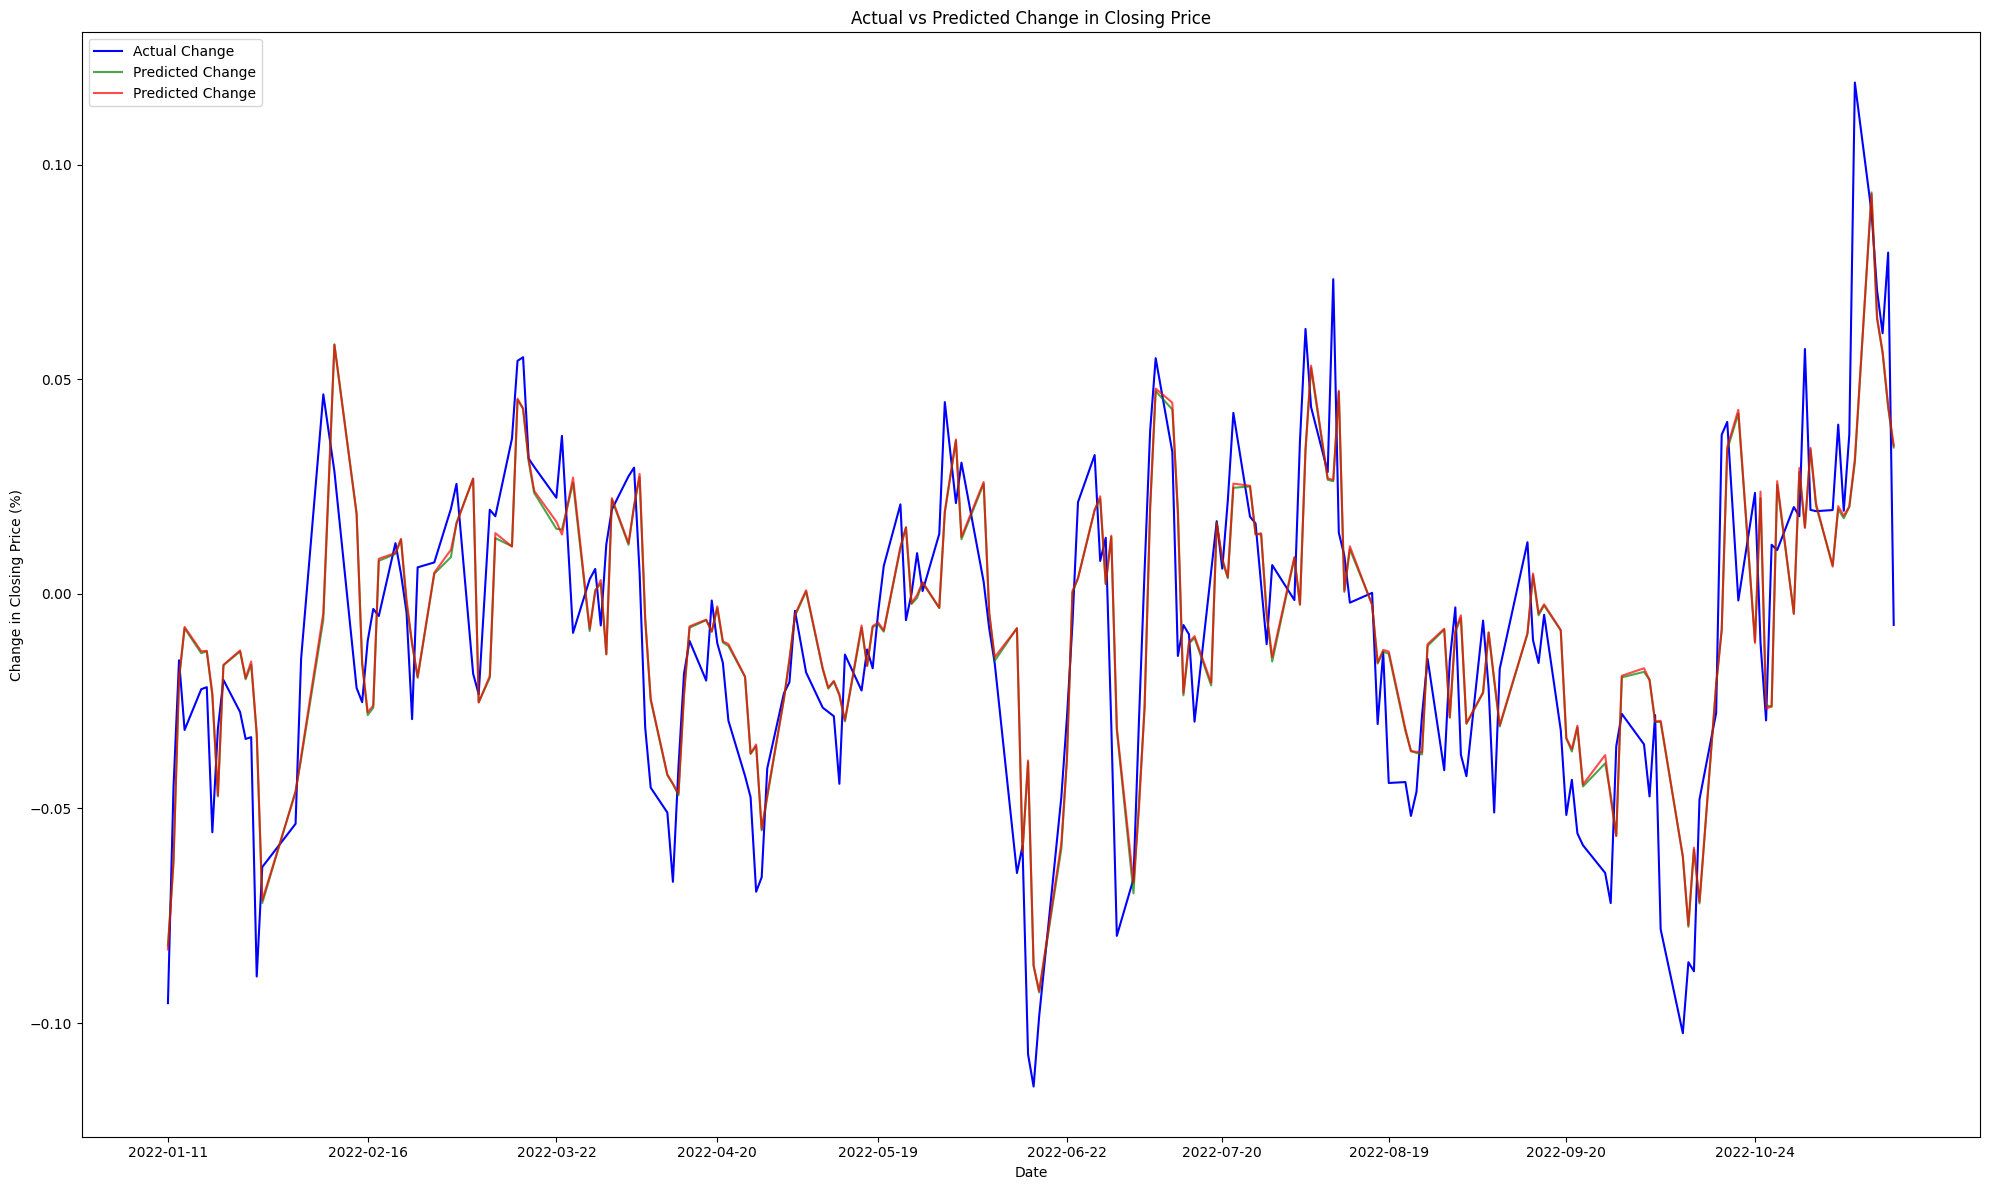

In [357]:
# 실제 종가 변화율과 ARIMA로 예측된 변화율을 시각화합니다.
plt.figure(figsize=(20, 12))
plt.plot(df_combined['Date'].iloc[400:600], df_combined['diff_5'].iloc[400:600], label='Actual Change', color='blue')
plt.plot(df_combined['Date'].iloc[400:600], df_combined['predicted_change_arima'].iloc[400:600], label='Predicted Change', color='green', alpha=0.7)
plt.plot(df_combined['Date'].iloc[400:600], df_combined['predicted_change_arimax'].iloc[400:600], label='Predicted Change', color='red', alpha=0.7)
plt.title('Actual vs Predicted Change in Closing Price')
plt.xlabel('Date')
plt.ylabel('Change in Closing Price (%)')
plt.xticks(df_combined['Date'].iloc[400:600][::20])
plt.tight_layout()
plt.legend()
plt.show()

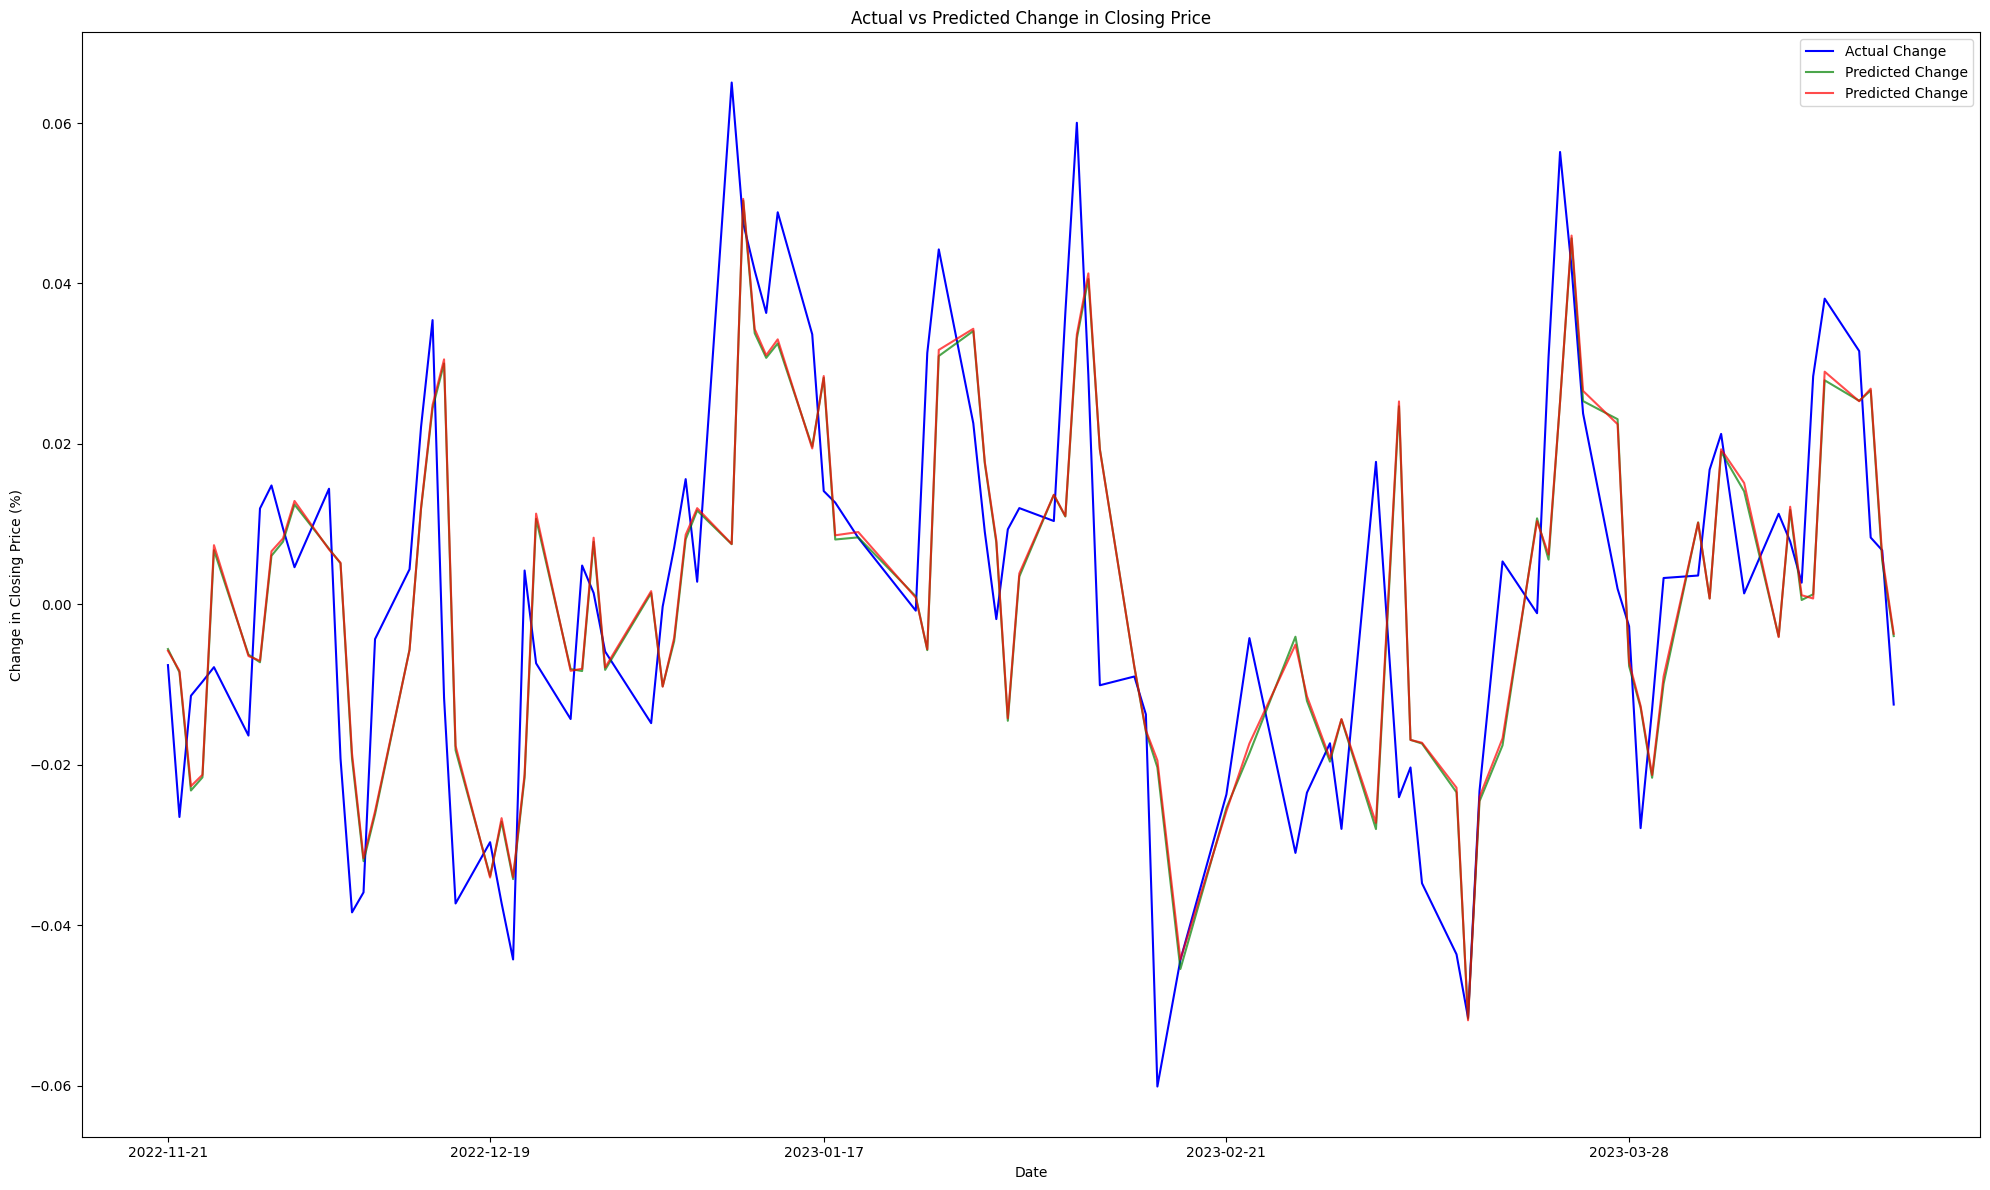

In [358]:
# 실제 종가 변화율과 ARIMA로 예측된 변화율을 시각화합니다.
plt.figure(figsize=(20, 12))
plt.plot(df_combined['Date'].iloc[600:], df_combined['diff_5'].iloc[600:], label='Actual Change', color='blue')
plt.plot(df_combined['Date'].iloc[600:], df_combined['predicted_change_arima'].iloc[600:], label='Predicted Change', color='green', alpha=0.7)
plt.plot(df_combined['Date'].iloc[600:], df_combined['predicted_change_arimax'].iloc[600:], label='Predicted Change', color='red', alpha=0.7)
plt.title('Actual vs Predicted Change in Closing Price')
plt.xlabel('Date')
plt.ylabel('Change in Closing Price (%)')
plt.xticks(df_combined['Date'].iloc[600:][::20])
plt.tight_layout()
plt.legend()
plt.show()